# Project Natural Computing

First we add some imports that are needed

In [92]:
import numpy as np
from copy import deepcopy
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt

Next, we define the activation functions. There is a choice between ReLU, Sigmoid and SoftMax

In [8]:
def ReLU(mat, gradient = False):
    if gradient:
        return mat * (mat > 0), 1 * (mat > 0)
    return mat * (mat > 0)

def Sigmoid(mat, gradient = False):
    sigm = 1/(1 + np.exp(-mat))
    if gradient:
        return sigm, sigm * (1 - sigm)
    return sigm

def SoftMax(mat, gradient = False):
    exp_mat = np.exp(mat - np.max(mat, axis = 1, keepdims = True))
    res_mat =  exp_mat/np.sum(exp_mat, axis = 1, keepdims = True)
    if gradient:
        return res_mat, res_mat * (1 - res_mat)
    return res_mat

Next, we have a network class which contains the number of layer, activation function, weights, biases and current fitness.

The forward function pushes the samples through the current network and returns the return values.

In [9]:
class Network:
    def __init__(self, node_seq, activation_functions, Xavier = True):
        self.node_seq = node_seq
        self.num_layers = len(node_seq) - 1
        self.activation = activation_functions
        self.weight_mats = []
        self.bias_vecs = []
        self.fitness = 0
        self.weight_mats_gradient = []
        self.bias_vecs_gradient = []
        for idx in range(self.num_layers):
            n_in = node_seq[idx]
            n_out = node_seq[idx + 1]
              # use Xavier initialization
            bound = np.sqrt(6/(n_in + n_out))
            if Xavier:
                self.weight_mats.append(np.random.uniform(-bound, bound, size = (n_in, n_out)))
            else: 
                self.weight_mats.append(np.zeros((n_in, n_out)))
            self.bias_vecs.append(np.zeros(n_out))
            self.weight_mats_gradient.append(np.zeros((n_in, n_out)))
            self.bias_vecs_gradient.append(np.zeros(n_out))
            
            
    def forward(self, samples, gradient = False):
        # note: give inputs in the form (samples, features)
        if not gradient:
            for idx in range(self.num_layers):
                samples = self.activation[idx](samples @ self.weight_mats[idx] + self.bias_vecs[idx])
            return samples
    
        n_samples = samples.shape[0]
        sample_list = [samples]
        current_sample = samples
        gradient_list = []
        layer_gradient = []
          
          # forward step
        for idx in range(self.num_layers):
            current_sample, current_gradient = self.activation[idx](current_sample @ 
                     self.weight_mats[idx] + self.bias_vecs[idx], gradient = True)
            gradient_list.append(current_gradient)
            sample_list.append(current_sample)
            n_in = self.node_seq[idx]
            n_out = self.node_seq[idx + 1]
            layer_gradient.append(np.zeros((n_samples, n_in)))
        
          # backward step
        layer_gradient.append(2*sample_list[self.num_layers])
        for idx in range(self.num_layers - 1, -1, -1):
            self.weight_mats_gradient[idx] = sample_list[idx].T @ layer_gradient[idx + 1]
            self.bias_vecs_gradient[idx] = np.ones(n_samples).T @ layer_gradient[idx + 1]
            layer_gradient[idx] = (layer_gradient[idx + 1] * gradient_list[idx]) @ self.weight_mats[idx].T 
        
        return current_sample
        
        
net = Network([2,2,2], [ReLU, SoftMax])
net.forward(np.array([[0,0], [0,1], [1,0], [1,1]]), True)

array([[0.5       , 0.5       ],
       [0.40876596, 0.59123404],
       [0.5       , 0.5       ],
       [0.49884416, 0.50115584]])

The next block defines several fitness functions

In [113]:
def cross_entropy_fitness(correct, predict):
    return max(np.sum(np.log(predict[range(predict.shape[0]), correct])) + predict.shape[0], 0)

  # computes fitness based on xor of all binary sequences of a given length
def xor_fitness(net, inputs, outputs, gradient = False):
    predict = net.forward(inputs, gradient)
    return cross_entropy_fitness(outputs, predict)

def xor_all_fitness(net, inputs, outputs, gradient = False):
    predict = net.forward(inputs, gradient)
    return np.log(predict[range(predict.shape[0]), outputs])

def xor_acc(net, inputs, outputs):
    predict = net.forward(inputs)
    return sum([outputs[i]==np.argmax(predict[i]) for i in range(0, len(outputs))])/len(predict)

def mnist_fitness(net, inputs, outputs, gradient = False):
    predict = net.forward(inputs, gradient)
    return cross_entropy_fitness(outputs, predict)

def cat_cross_entropy_fitness(correct, predict):
    loss = 0.0
    for true, pred in zip(correct, predict):
        loss += np.log(pred[true-1])

In this section, we define crossover and mutation operators

In [11]:
def crossover_minimax(net1, net2):
    node_seq = net1.node_seq
    activation = net1.activation
    new_net1 = Network(node_seq, activation, Xavier = False)
    new_net2 = Network(node_seq, activation, Xavier = False)
    for idx in range(net1.num_layers): #perhaps random choice, instead of one net all minima and one net all maxima
        new_net1.weight_mats[idx] = np.minimum(net1.weight_mats[idx], net2.weight_mats[idx])
        new_net2.weight_mats[idx] = np.maximum(net1.weight_mats[idx], net2.weight_mats[idx])
        new_net1.bias_vecs[idx] = np.minimum(net1.bias_vecs[idx], net2.bias_vecs[idx])
        new_net2.bias_vecs[idx] = np.maximum(net1.bias_vecs[idx], net2.bias_vecs[idx])
    return new_net1, new_net2
    
def crossover_layer(net1, net2):
    node_seq = net1.node_seq
    activation = net1.activation
    new_net1 = Network(node_seq, activation, Xavier = False)
    new_net2 = Network(node_seq, activation, Xavier = False)
    select_layers = np.random.uniform(size = net1.num_layers)
    for idx in range(net1.num_layers): 
        if select_layers[idx] < 0.5:
            new_net1.weight_mats[idx] = net1.weight_mats[idx]
            new_net2.weight_mats[idx] = net2.weight_mats[idx]
            new_net1.bias_vecs[idx] = net1.bias_vecs[idx]
            new_net2.bias_vecs[idx] = net2.bias_vecs[idx]
        else:
            new_net1.weight_mats[idx] = net2.weight_mats[idx]
            new_net2.weight_mats[idx] = net1.weight_mats[idx]
            new_net1.bias_vecs[idx] = net2.bias_vecs[idx]
            new_net2.bias_vecs[idx] = net1.bias_vecs[idx]
    return new_net1, new_net2
    
def mut_layer(net, gradient = False):
    mut_size = np.random.uniform()
    select_layers = np.random.uniform(size = net.num_layers)
    for idx in range(net.num_layers): 
        if select_layers[idx] < 0.5:
            n_in = net.node_seq[idx]
            n_out = net.node_seq[idx + 1]
            bound = np.sqrt(6/(n_in + n_out)) * mut_size
            if gradient:
                net.weight_mats[idx] += np.random.uniform(-mut_size, mut_size, \
                     size = (n_in, n_out)) / np.sqrt(np.maximum(np.abs(net.weight_mats_gradient[idx]), 0.01))
                net.bias_vecs[idx] += np.random.uniform(-mut_size, mut_size, \
                     size = n_out) /  np.sqrt(np.maximum(np.abs(net.bias_vecs_gradient[idx]), 0.01))
            else:
                bound = np.sqrt(6/(n_in + n_out)) * mut_size
                net.weight_mats[idx] += np.random.uniform(-bound, bound, size = (n_in, n_out))
                net.bias_vecs[idx] += np.random.uniform(-bound, bound, size = n_out)

def mut_index(net, gradient = False):
    mut_size = np.random.uniform()
    idx = int(np.random.choice(net.num_layers, 1))
    n_in = net.node_seq[idx]
    n_out = net.node_seq[idx + 1]
    idx2 = int(np.random.choice(n_in, 1))
    idx3 = int(np.random.choice(n_out, 1))
    if gradient:
        net.weight_mats[idx][idx2][idx3] += np.random.uniform(-mut_size, mut_size, \
            size = 1) / np.sqrt(np.maximum(np.abs(net.weight_mats_gradient[idx][idx2][idx3]), 0.01))
    else:
        bound = np.sqrt(6/(n_in + n_out)) * mut_size
        net.weight_mats[idx][idx2][idx3] += np.random.uniform(-bound, bound, size = 1)


The class Genetic defines the neuroevolution algorithm

In [53]:
class Genetic:
    def __init__(self, pop_size, node_seq, activation_functions, fitness_function, 
                 inp, outp, mutation_functions, mutation_probabilities, 
                 crossover_functions, crossover_probabilities, elite, gradient = False):
        self.net_list = []
        self.pop_size = pop_size
        for idx in range(pop_size):
            self.net_list.append(Network(node_seq, activation_functions))
        
        self.fitness_func = fitness_function
        self.inp = inp
        self.outp = outp
        self.grad = gradient
        self.mutation_func = mutation_functions
        self.mutation_threshold = np.cumsum(mutation_probabilities)
        self.crossover_func = crossover_functions
        self.crossover_threshold = np.cumsum(crossover_probabilities)
        self.elite = elite
        self.current_best_fitness = 0
        self.hist = []
        self.full_hist = []
        
    def next_generation(self):
        if self.current_best_fitness + 0.001 > self.max_fitness:
            pass # continuing to evolve (near-)optimal solutions can lead to instability
        
        new_net_idx = np.random.permutation(self.pop_size)
        new_net_list = [deepcopy(self.net_list[idx]) for idx in new_net_idx]
        
        select_mutate = np.random.uniform(size=self.pop_size)
        for idx in range(self.pop_size):
            for mut_idx in range(len(self.mutation_func)):
                  # select mutation mut_idx if self.mutation_threshold[mut_idx-1] <
                  # select_mutate[idx] < self.mutation_threshold[mut_idx]
                if select_mutate[idx] < self.mutation_threshold[mut_idx]:
                    self.mutation_func[mut_idx](new_net_list[idx], self.grad)
                    break 
                    
        cross_net_idx = np.random.permutation(self.pop_size)
        cross_net_list = [deepcopy(self.net_list[idx]) for idx in cross_net_idx]
        select_cross = np.random.uniform(size = self.pop_size)
        for idx in range(self.pop_size//2):
            for cross_idx in range(len(self.crossover_func)):
                if select_cross[idx] < self.crossover_threshold[cross_idx]:
                    cross_net_list[2*idx], cross_net_list[2*idx + 1] =  \
                      self.crossover_func[cross_idx](cross_net_list[2*idx], \
                                                     cross_net_list[2*idx + 1])
                    
        new_net_list.extend(cross_net_list)
        new_net_list.extend(self.net_list)
        for net in new_net_list:
            net.fitness = self.fitness_func(net, self.inp, self.outp, self.grad)
        
        new_net_list.sort(key = lambda x: -x.fitness)
        fitnesses = [net.fitness for net in new_net_list]
        probabilities = fitnesses / np.sum(fitnesses)
        net_idx = np.random.choice(len(new_net_list), self.pop_size - self.elite, p = probabilities)
        self.net_list = [new_net_list[idx] for idx in net_idx]
        self.net_list.extend(new_net_list[:self.elite])

        self.net_list.sort(key = lambda x: -x.fitness)
        if self.net_list[0].fitness > 0.0001 + self.current_best_fitness:
            self.current_best_fitness = self.net_list[0].fitness
        self.hist.append(self.net_list[0].fitness)

# Tests

In [54]:
# Different lengths input
# LENGTH 2
seq_len = 2
X2 = [[(num >> idx) % 2 for idx in range(seq_len)] for num in range(2**seq_len)]
y2 = [sum(seq) % 2 for seq in X2]
X2_train, X2_test, y2_train, y2_test = model_selection.train_test_split(X2, y2, test_size=0.33, random_state=42, shuffle=True)

# LENGTH 4
seq_len = 4
X4 = [[(num >> idx) % 2 for idx in range(seq_len)] for num in range(2**seq_len)]
y4 = [sum(seq) % 2 for seq in X4]
X4_train, X4_test, y4_train, y4_test = model_selection.train_test_split(X4, y4, test_size=0.33, random_state=42, shuffle=True)

# LENGTH 8
seq_len = 6
X6 = [[(num >> idx) % 2 for idx in range(seq_len)] for num in range(2**seq_len)]
y6 = [sum(seq) % 2 for seq in X6]
X6_train, X6_test, y6_train, y6_test = model_selection.train_test_split(X6, y6, test_size=0.33, random_state=42, shuffle=True)

In [49]:
probabilities = [
    ([1, 0, 1, 0], "mut_layer + cross_minimax"),
    ([1, 0, 0, 1], "mut_layer + cross_layer"),
    ([1, 0, 0.5, 0.5], "mut_layer + both cross"),
    ([0, 1, 1, 0], "mut_index + cross_minimax"),
    ([0, 1, 0, 1], "mut_index + cross_layer"),
    ([0, 1, 0.5, 0.5], "mut_index + both cross"),
    ([0.5, 0.5, 1, 0], "both mut + cross_minimax"),
    ([0.5, 0.5, 0, 1], "both mut + cross_layer"),
    ([0.5, 0.5, 0.5, 0.5], "all active")
]

In [80]:
def run_algo_xor(seq_len, x_train, y_train, x_test, y_test, nr_of_gens, prob):
    fitness_sum = []
    full_hist_sum = []
    for i in range(0, 10) :
        genetic_algo = Genetic(50, [seq_len, 6, 2], [ReLU, SoftMax], xor_fitness, 
                            x_train, y_train,
                            [mut_layer, mut_index], [prob[0], prob[1]], 
                            [crossover_minimax, crossover_layer], [prob[2], prob[3]], 1)
        for gen in range(nr_of_gens):
            genetic_algo.next_generation()
        opt_net = genetic_algo.net_list[0]
        xor_all_fitness(opt_net, x_test, y_test)
        fitness_sum.append(genetic_algo.hist)
        full_hist_sum.append(genetic_algo.full_hist)
    return fitness_sum, full_hist_sum

    
def try_probs(seq_len, x_train, y_train, x_test, y_test, nr_of_gens, probs):
    all_hists = []
    for (p, label) in probs:
        fitness_sum, full_hist_sum = run_algo_xor(seq_len, x_train, y_train, x_test, y_test, nr_of_gens, p)
        all_hists.append((fitness_sum, full_hist_sum, label))
    return all_hists
        
def plot_probs(nr_of_gens, all_hists):
    plt.rcParams["figure.figsize"] = (15,8)
    for (fitness, label) in all_hists:
        plt.plot(range(0,nr_of_gens), fitness[:nr_of_gens], label = label)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.title("Performance of the neuroevolution algorithm with different crossover / mutation probabilities.")
    plt.show()
    
def plot_probs2(nr_of_gens, all_hists):
    fig = plt.figure(figsize=(20,30))
    for i in range(0, 9):
        full_hist = all_hists[i][1][0]
        fitness = all_hists[i][0][0]
        label = all_hists[i][2]
        mean = np.array([np.mean(i) for i in full_hist])
        std = np.array([np.std(i) for i in full_hist])

        plt.subplot(5, 2, i+1)
        # plt.rcParams["figure.figsize"] = (15,8)
        plt.plot(range(0,nr_of_gens), fitness, label="Max fitness")
        #plt.plot(range(0,nr_of_gens), [min(i) for i in full_hist], label="Min fitness")
        plt.plot(range(0,nr_of_gens), mean, label="Mean fitness")
        plt.fill_between(range(0,nr_of_gens), mean-std, mean+std, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', label="Std around mean")
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        plt.legend()
        plt.title(label)
    plt.show()

In [61]:
all_hists2_2 = try_probs(2, np.array(X2_train), np.array(y2_train), np.array(X2_test), np.array(y2_test), 200, probabilities)

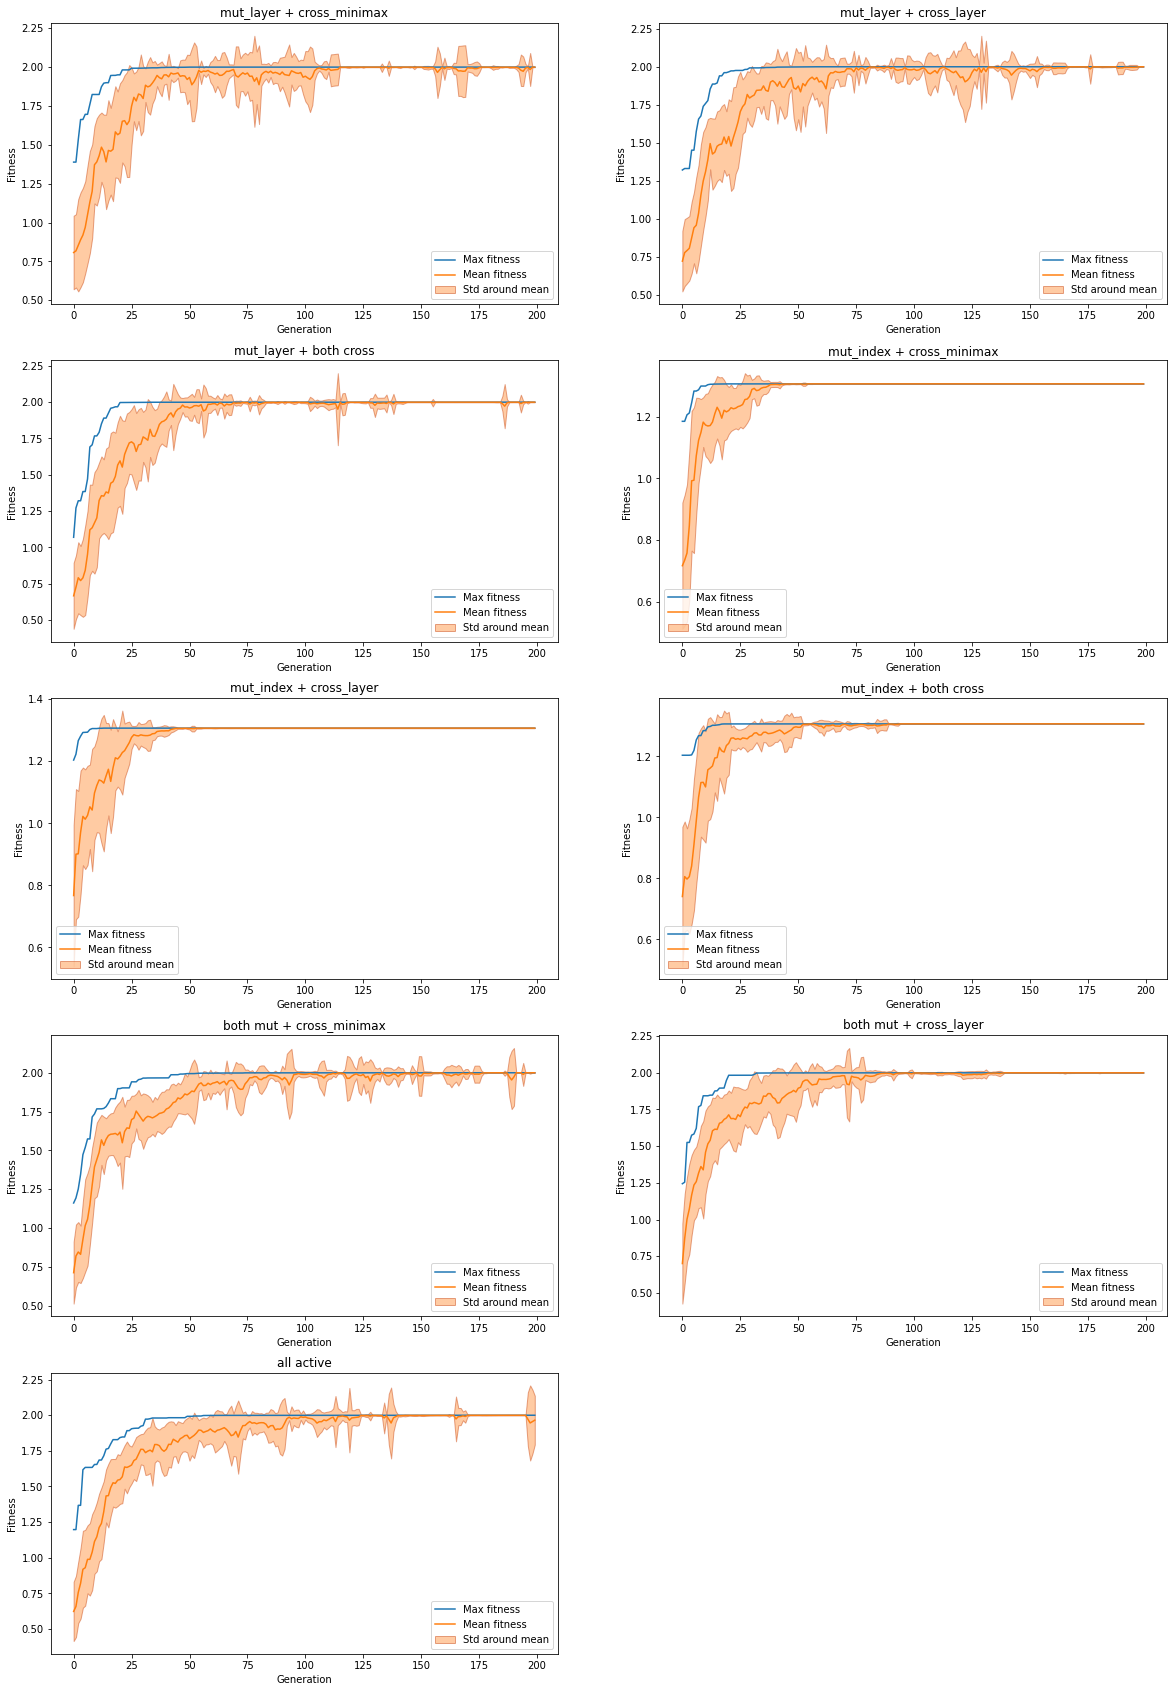

In [64]:
plot_probs2(200, all_hists2_2)

In [75]:
for i in range(0, 9):
    fitness = np.array(all_hists2_2[i][0][0])
    fitness_idx = np.argmax(fitness)
    fitness_max = np.max(fitness)
    print(fitness_idx)
    print(fitness_max)

197
1.9999999999743274
122
2.0
92
2.0
64
1.3068528194400546
57
1.3068528194400546
70
1.3068528194400546
198
1.9999999985335253
100
2.0
186
1.999999998945783


In [28]:
all_hists4_2 = try_probs(4, X4_train, y4_train, X4_test, y4_test, 1000, probabilities)

IndexError: list index out of range

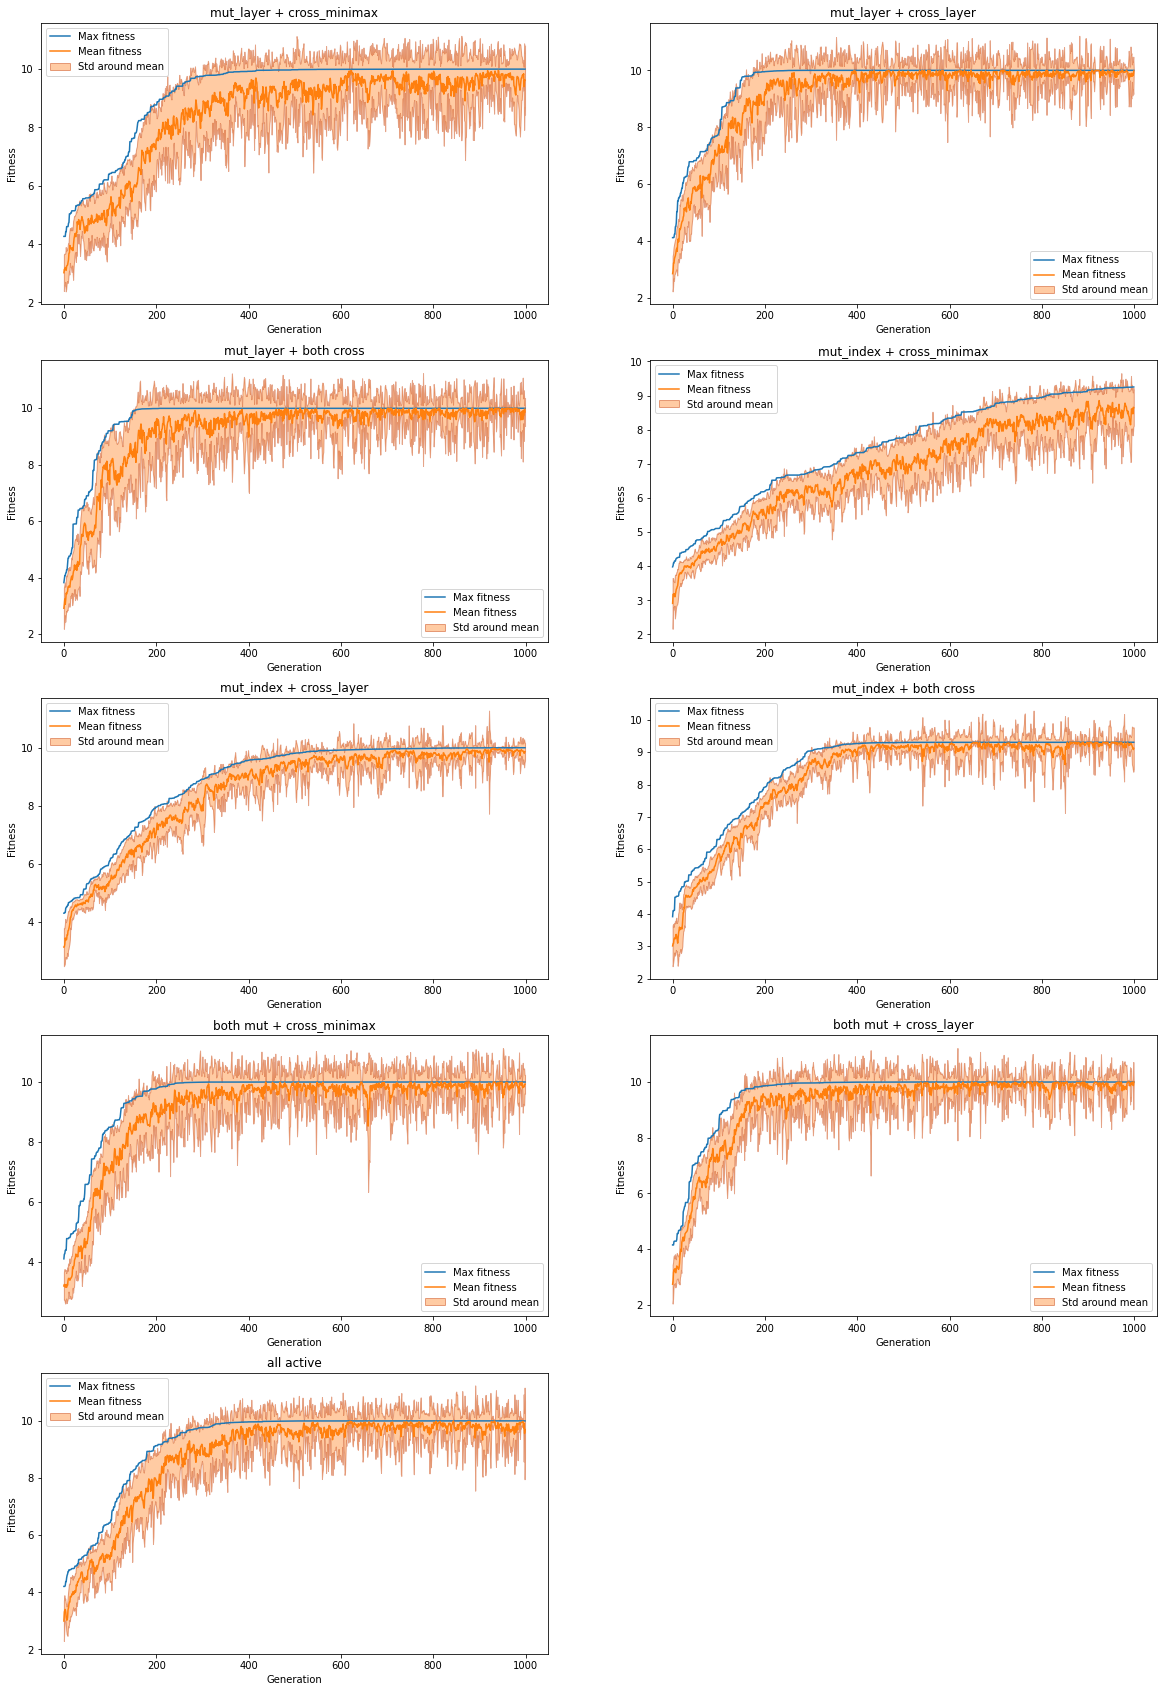

In [29]:
plot_probs2(1000, all_hists4_2)

In [74]:
for i in range(0, 9):
    fitness = np.array(all_hists4_2[i][0][0])
    fitness_idx = np.argmax(fitness)
    fitness_max = np.max(fitness)
    print(fitness_idx)
    print(fitness_max)

992
9.999894035392135
803
10.0
855
10.0
998
9.251921771519521
999
9.99909309530153
997
9.306852495698854
994
9.99999999999999
994
9.999999999823464
999
9.999999692075214


In [83]:
all_hists6_2 = try_probs(6, X6_train, y6_train, X6_test, y6_test, 2000, probabilities)

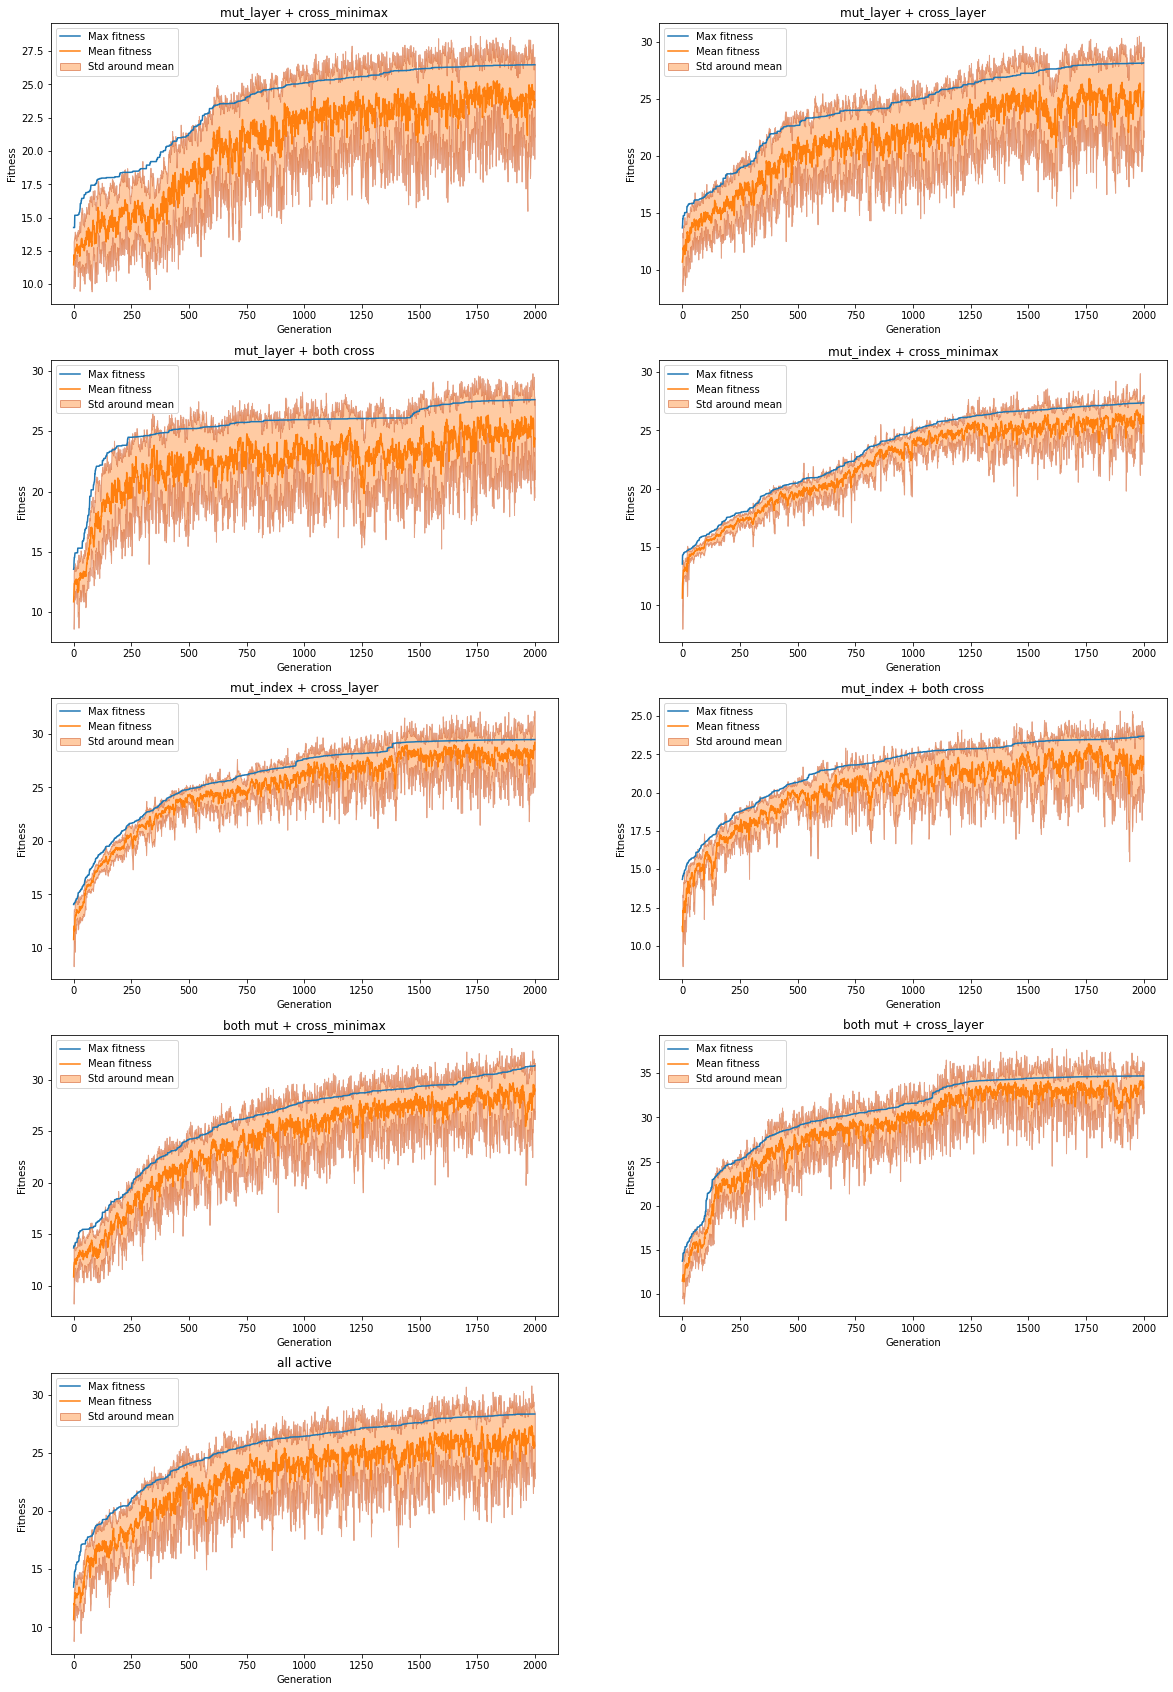

In [85]:
plot_probs2(2000, all_hists6_2)

In [86]:
for i in range(0, 9):
    fitness = np.array(all_hists6_2[i][0][0])
    fitness_idx = np.argmax(fitness)
    fitness_max = np.max(fitness)
    print(fitness_idx)
    print(fitness_max)

1998
26.48482924406731
1999
28.156757834893714
1992
27.607874155059406
1999
27.360685619575207
1996
29.480477029765172
1996
23.690756426615547
1997
31.361169032095304
1996
34.69010734675806
1992
28.342664593787532


# MNIST

In [88]:
from sklearn.datasets import load_digits

In [89]:
mnist = load_digits()

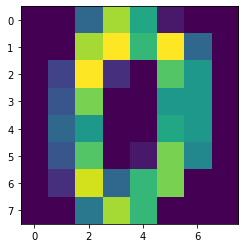

In [90]:
plt.imshow(mnist.images[0]);

In [94]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(mnist.data, mnist.target, test_size=0.33, random_state=42)

print(np.shape(x_train))
print(np.shape(x_test))

(1203, 64)
(594, 64)


In [111]:
def run_algo_mnist(x_train, y_train, x_test, y_test, nr_of_gens, prob):
    fitness_sum = []
    full_hist_sum = []
    for i in range(0, 10) :
        genetic_algo = Genetic(20, [64, 20, 10], [ReLU, SoftMax], mnist_fitness_acc, 
                            x_train, y_train,
                            [mut_layer, mut_index], [prob[0], prob[1]], 
                            [crossover_minimax, crossover_layer], [prob[2], prob[3]], 1)
        for gen in range(nr_of_gens):
            genetic_algo.next_generation()
        opt_net = genetic_algo.net_list[0]
        mnist_fitness(opt_net, x_test, y_test)
        fitness_sum.append(genetic_algo.hist)
        full_hist_sum.append(genetic_algo.full_hist)
    return fitness_sum, full_hist_sum

    
def try_probs_mnist(x_train, y_train, x_test, y_test, nr_of_gens, probs):
    all_hists = []
    for (p, label) in probs:
        fitness_sum, full_hist_sum = run_algo_mnist(x_train, y_train, x_test, y_test, nr_of_gens, p)
        all_hists.append((fitness_sum, full_hist_sum, label))
    return all_hists

In [114]:
all_hists_mnist = try_probs_mnist(x_train, y_train, x_test, y_test, 500, probabilities)

c:\users\loesk\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
c:\users\loesk\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
c:\users\loesk\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


KeyboardInterrupt: 